In [1]:
import torch
from transformers import AutoTokenizer, AutoModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
text_model_name = "sentence-transformers/all-MiniLM-L6-v2"
tok = AutoTokenizer.from_pretrained(text_model_name)
base_text_model = AutoModel.from_pretrained(text_model_name).to(device)
print(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


cuda


In [2]:
from matplotlib import pyplot as plt

# Helper function to visualize performance during training, courtsey of HW4
def plot_training_curves(train_losses, val_losses):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(train_losses)
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True)

    ax2.plot(val_losses)
    ax2.set_title('Validation Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn.functional as F

# Standard Spotify Features
REQUIRED_FEATURE_MAP = {
    "energy": ["energy"],
    "danceability": ["danceability"],
    "valence": ["valence"],
    "tempo": ["tempo"],
    "loudness": ["loudness"],
    "acousticness": ["acousticness"],
    "liveness": ["liveness"],
    "speechiness": ["speechiness"],
    "instrumentalness": ["instrumentalness"],
    "time_signature": ["time_signature", "time signature"],  # Handle space
    "mode": ["mode"],
    "key": ["key"]
}

REQUIRED_TEXT_MAP = {
    "track_id": ["track_id", "track uri"],
    "track_name": ["track_name", "track name", "track"],
    "track_artist": ["track_artist", "artist", "artist name(s)"],
    "playlist_genre": ["playlist_genre", "genres"],
    "playlist_subgenre": ["playlist_subgenre", "subgenre"],
    "playlist_name": ["playlist_name"],
    "gemini_review": ["gemini_review"],
    "small_text": ["small_text"],
}


def clean_dataframe(df: pd.DataFrame) -> tuple:
    # 1. Create a lowercase map of the uploaded DataFrame's columns
    df_cols_map = {col.lower(): col for col in df.columns}
    renaming_dict = {}
    all_required_maps = {**REQUIRED_FEATURE_MAP, **REQUIRED_TEXT_MAP}

    for standard_name, possible_sources in all_required_maps.items():
        found = False
        for source_name in possible_sources:
            if source_name.lower() in df_cols_map:
                original_col = df_cols_map[source_name.lower()]
                if original_col != standard_name:
                    renaming_dict[original_col] = standard_name
                found = True
                break

        if not found and standard_name not in df.columns:
            df[standard_name] = np.nan
            print(f"Added missing column: {standard_name}")

    if renaming_dict:
        df.rename(columns=renaming_dict, inplace=True)
        print(f"Columns renamed/standardized: {list(renaming_dict.items())}")
    else:
        print("No columns required renaming.")

    feature_cols = list(REQUIRED_FEATURE_MAP.keys())

    # --- NaN Handling for feature_cols ---
    if df[feature_cols].isnull().any().any():
        print("NaN values found in feature_cols. Imputing with mean...")
        for col in feature_cols:
            if df[col].isnull().any():
                df[col] = df[col].fillna(df[col].mean())
        print("NaN values handled.")
    else:
        print("No NaN values found in feature_cols.")

    print(f"Initial DataFrame shape: {df.shape}")

    # --- Duplicate Removal ---
    # If 'track_id' column exists, use it for duplicate removal
    if 'track_id' in df.columns:
        initial_unique_tracks = df['track_id'].nunique()
        print(f"Number of unique track_ids before dropping: {initial_unique_tracks}")
        df.drop_duplicates(subset=['track_id'], keep='first', inplace=True)
        print("Duplicates removed based on 'track_id'.")
    else:
        # If 'track_id' is not available, use 'track_name' and 'track_artist'
        print("Warning: 'track_id' column not found. Removing duplicates based on 'track_name' and 'track_artist'.")
        initial_unique_tracks = df.groupby(['track_name', 'track_artist']).ngroups
        print(f"Number of unique track_name/track_artist combinations before dropping: {initial_unique_tracks}")
        df.drop_duplicates(subset=['track_name', 'track_artist'], keep='first', inplace=True)
        print("Duplicates removed based on 'track_name' and 'track_artist'.")

    print(f"DataFrame shape after removing duplicates: {df.shape}")

    # Extract Spotify features for scaling and training targets from the de-duplicated DataFrame
    X = df[feature_cols].values.astype("float32")

    # Scale features to mean 0 / std 1 so dimensions are comparable (re-fit on cleaned data)
    scaler = StandardScaler()  # Re-initialize scaler to fit on the cleaned data
    X_scaled = scaler.fit_transform(X)

    # Turn into a normalized torch tensor -> this is your SONG EMBEDDING MATRIX for initial search
    song_embeds = torch.tensor(X_scaled)
    song_embeds = F.normalize(song_embeds, dim=-1)  # (num_songs, d)

    # Prepare the comprehensive text column for model training from the de-duplicated DataFrame
    df["text"] = (
            # df["track_name"].fillna("") + " by " +
            # df["track_artist"].fillna("") + ". " +
            df["playlist_genre"].fillna("") + " " +
            df["playlist_subgenre"].fillna("") + " " +
            df["playlist_name"].fillna("") + ". " +
            df["gemini_review"].fillna("") + "" +
            df["small_text"].fillna("") + " "
            # df["review"].fillna("")
    )

    # Clean up extra spaces that might result from concatenating with empty strings
    df["text"] = df["text"].str.replace(r'\s+', ' ', regex=True).str.strip()

    texts = df["text"].tolist()
    targets = torch.tensor(X_scaled, dtype=torch.float32)  # target = scaled Spotify features

    print("\nSpotify features (X_scaled) shape:", X_scaled.shape)
    print("Song embeddings (song_embeds) shape:", song_embeds.shape)
    print("Number of texts for training:", len(texts))
    print("Targets shape:", targets.shape)
    print("First few combined texts:")
    for i in range(5):
        print(f"  - {texts[i][:150]}...")

    return df, feature_cols, targets, texts, song_embeds

In [4]:
from torch import nn
from torch.utils.data import Dataset

class SongTextDataset(Dataset):
    def __init__(self, texts, targets):
        self.texts = texts
        self.targets = targets

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, i):
        enc = tok(
            self.texts[i],
            truncation=True,
            padding="max_length",
            max_length=64,
            return_tensors="pt",
        )
        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "target": self.targets[i],
        }

class TextToSpotifyFeatures(nn.Module):
    def __init__(self, encoder, out_dim):
        super().__init__()
        self.encoder = encoder
        hidden_dim = encoder.config.hidden_size
        self.head = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, out_dim),
        )

    def forward(self, input_ids, attention_mask):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        x = (out.last_hidden_state * attention_mask.unsqueeze(-1)).sum(1)
        x = x / attention_mask.sum(1, keepdim=True)
        return self.head(x)

                 track_id  energy    tempo  danceability playlist_genre  \
0  2plbrEY59IikOBgBGLjaoe   0.592  157.969         0.521            pop   
1  6dOtVTDdiauQNBQEDOtlAB   0.507  104.978         0.747            pop   
2  7ne4VBA60CxGM75vw0EYad   0.808  108.548         0.554            pop   
3  1d7Ptw3qYcfpdLNL5REhtJ   0.910  112.966         0.670            pop   
4  5vNRhkKd0yEAg8suGBpjeY   0.783  149.027         0.777            pop   

   loudness  liveness  valence           track_artist  time_signature  ...  \
0    -7.777     0.122    0.535  Lady Gaga, Bruno Mars             3.0  ...   
1   -10.171     0.117    0.438          Billie Eilish             4.0  ...   
2    -4.169     0.159    0.372          Gracie Abrams             4.0  ...   
3    -4.070     0.304    0.786      Sabrina Carpenter             4.0  ...   
4    -4.477     0.355    0.939       ROSÉ, Bruno Mars             4.0  ...   

   instrumentalness  mode  key acousticness playlist_subgenre  rating  \
0      

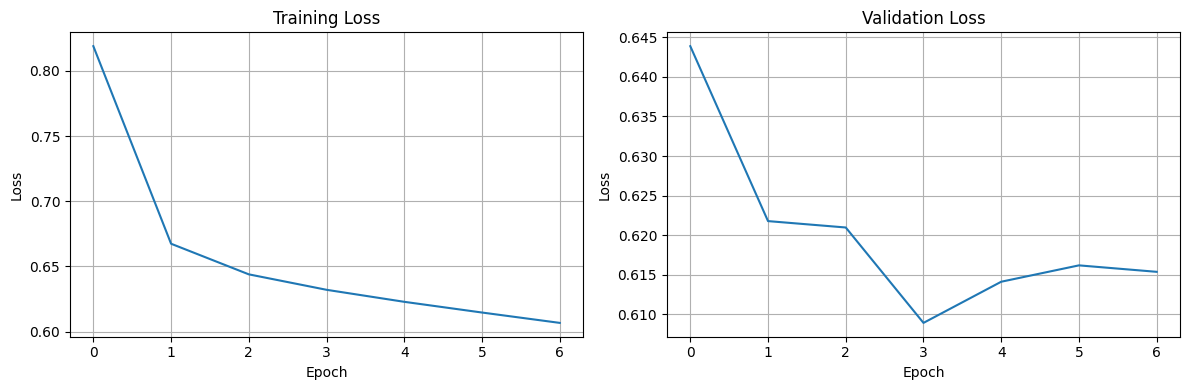


--- Final Test Evaluation ---
Final Test MSE: 0.6365


In [5]:
from torch.utils.data import DataLoader
import pandas as pd
import torch
from torch import nn
from sklearn.model_selection import train_test_split


def load_dataframe(file_path):
    df = pd.read_csv(file_path)
    print(df.head())
    return df

def update_df(dataframe: pd.DataFrame):
    return clean_dataframe(dataframe)


def evaluate_model(model, loader, loss_fn):
    """Calculates the loss on the provided dataset loader (typically the test set)."""
    model.eval() # Set model to evaluation mode
    total_loss = 0.0
    with torch.no_grad(): # Disable gradient calculation
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attn = batch["attention_mask"].to(device)
            target = batch["target"].to(device)

            pred = model(input_ids, attn)
            loss = loss_fn(pred, target)
            total_loss += loss.item() * input_ids.size(0)

    # Return the average loss (Mean Squared Error)
    return total_loss / len(loader.dataset)


train_losses = []
val_losses = []

def train_model(
    model,
    train_loader,
    val_loader,
    loss_fn,
    opt,
    n_epochs: int = 10,
    patience: int = 5,
    save_path: str | None = None,
):
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in range(n_epochs):
        # --- Training Step ---
        model.train()
        train_total_loss = 0.0
        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)
            attn = batch["attention_mask"].to(device)
            pred = model(input_ids, attn)
            target = batch["target"].to(device)

            loss = loss_fn(pred, target)

            opt.zero_grad()
            loss.backward()
            opt.step()
            train_total_loss += loss.item() * input_ids.size(0)


        current_val_loss = evaluate_model(model, val_loader, loss_fn)
        avg_train_loss = train_total_loss / len(train_loader.dataset)

        print(
            f"Epoch {epoch + 1:2d} | "
            f"Train MSE: {avg_train_loss:.4f} | "
            f"Validation MSE: {current_val_loss:.4f}"
        )
        train_losses.append(avg_train_loss)
        val_losses.append(current_val_loss)

        if current_val_loss < best_val_loss:
            best_val_loss = current_val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
            print(f"    ⭐ Validation loss improved. Saving current model state.")
        else:
            patience_counter += 1
            print(f"Validation loss did not improve. Patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch + 1} epochs (Patience {patience} exceeded).")
            if best_model_state is not None:
                model.load_state_dict(best_model_state)
                print("Loaded best model weights.")
            break

    # --- Final Save ---
    # Save the *best* model state (the one with the lowest validation loss)
    if save_path is not None and best_model_state is not None:
        # If the loop completed normally, or broke early, save the best state found.
        torch.save(best_model_state, save_path)
        print(f"\nFinal best model parameters saved to {save_path} (Best Val MSE: {best_val_loss:.4f})")


if __name__ == "__main__":
    df = load_dataframe("/content/drive/MyDrive/spotifySongData/spotify_all_songs_with_review_cols_updated.csv")
    df, feature_cols, targets, texts, song_text_to_embed = update_df(df)

    train_texts, temp_texts, train_targets, temp_targets = train_test_split(
    texts, targets, test_size=0.2, random_state=42
    )

    # 2. Split temporary data into validation (50% of temp) and test (50% of temp)
    # This results in a final split like 80% Train, 10% Validation, 10% Test
    val_texts, test_texts, val_targets, test_targets = train_test_split(
        temp_texts, temp_targets, test_size=0.5, random_state=42 # 0.5 of 0.2 is 0.1 (10%)
    )

    # Create the Validation Loader
    val_dataset = SongTextDataset(val_texts, val_targets)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    train_dataset = SongTextDataset(train_texts, train_targets)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    test_dataset = SongTextDataset(test_texts, test_targets)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    spot_model = TextToSpotifyFeatures(base_text_model, out_dim=len(feature_cols)).to(device)
    optimizer = torch.optim.Adam(spot_model.parameters(), lr=1e-4)
    loss_function = nn.MSELoss()

    print(f"Total Samples: {len(df)}")
    print(f"Training Samples: {len(train_dataset)}")
    print(f"Test Samples: {len(test_dataset)}")
    print(f"Model initialized with output dimension: {len(feature_cols)}")

    train_model(
        spot_model,
        train_loader,
        val_loader,
        loss_function,
        optimizer,
        n_epochs=10,
        save_path="spotify_model_weights.pth",
        patience=3
    )
    plot_training_curves(train_losses, val_losses)
    final_test_mse = evaluate_model(spot_model, test_loader, loss_function)
    print(f"\n--- Final Test Evaluation ---")
    print(f"Final Test MSE: {final_test_mse:.4f}")